<a href="https://colab.research.google.com/github/navneetkrc/Recommender_systems/blob/master/AJ_Job_analysis_content_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to gdrive to get the datasets

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [2]:
!ls -ls "/content/gdrive/My Drive/AJ_DATA"

total 3615058
 256552 -rw------- 2 root root  262708619 Jul 15 10:52 aj_data.csv
2492314 -rw------- 1 root root 2552128877 Jul 16 07:15 can_resume_with_int_ids.csv
 559976 -rw------- 1 root root  573414642 Jul 16 09:28 final_candidate.csv
  49162 -rw------- 1 root root   50341492 Jul 16 09:28 final_jobs.csv
 257056 -rw------- 3 root root  263224431 Jul 15 12:28 job_jds_with_int_ids.csv


## Importing libraries

In [0]:
import pandas as pd
import numpy as np
import nltk


## Load the data

Loading the jobs dataset

In [4]:
df_jobs = pd.read_csv("/content/gdrive/My Drive/AJ_DATA/job_jds_with_int_ids.csv")
df_jobs.head(3)

,Unnamed: 0,description.text,functional_areas,gender_preference,industry_name,job_id,mandatory_keywords,mobile_ownership,normalized_min_salary,optional_keywords,places_formatted_address,proficiency,salary_slab,skills,title,vehicle_ownership,work_exp_requirements,clean_jds,title_refined,combined_jd_title,int_ids
0,0,Sales & Channel Objectives· Ensure primary / S...,Sales / Business Development,D,Electronics / Electrical,bdfb54d8-b6a5-43b8-9f2a-448ac2d180a7,[u'Product'],NaN,166667.0,"[u'Packing', u'Recruitment', u'English', u'Sal...","Kolkata, West Bengal 700001, India",4proficiency,M,[],Zonal Sales Head (Regional Head - Kolkate),NaN,experienced,"['sales', 'channel', 'objectives', 'ensure', '...","['zonal', 'sales', 'head', 'regional', 'head',...","['zonal', 'sales', 'head', 'regional', 'head',...",0
1,1,Hiring for Account Executive at Chandivali Loc...,Accountant,F,Automobile,bdb7106a-9a19-4e6c-8f49-6b724461d49d,"[u'Petty Cash Handling', u'Bachelor of Commerc...",NaN,10000.0,"[u'TDS', u'English', u'Hindi', u'Sales', u'Tal...","Chandivali, Powai, Mumbai, Maharashtra, India",4proficiency,M,"[{u'id': 522, u'name': u'Cash Management'}, {u...",Accounts Executive,NaN,experienced,"['hiring', 'for', 'account', 'executive', 'at'...","['accounts', 'executive']","['accounts', 'executive', 'hiring', 'for', 'ac...",1
2,2,Incredible job opportunity to work as part-tim...,Back Office Executive,D,Travel / Tourism,078c18e0-d766-4b7e-8b3d-5f6b9d44041a,[],NaN,25000.0,"[u'Marketing', u'Marketing Officer']","Andheri East, Mumbai, Maharashtra, India",1proficiency,M,"[{u'id': 505, u'name': u'Computer Awareness'}]",Marketing Officer,NaN,fresher,"['incredible', 'job', 'opportunity', 'to', 'wo...","['marketing', 'officer']","['marketing', 'officer', 'incredible', 'job', ...",2


In [5]:
df_jobs.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87819 entries, 0 to 87818
Data columns (total 21 columns):
Unnamed: 0                  87819 non-null int64
description.text            87795 non-null object
functional_areas            87819 non-null object
gender_preference           87819 non-null object
industry_name               87818 non-null object
job_id                      87819 non-null object
mandatory_keywords          87819 non-null object
mobile_ownership            1710 non-null object
normalized_min_salary       87811 non-null float64
optional_keywords           87819 non-null object
places_formatted_address    87819 non-null object
proficiency                 87819 non-null object
salary_slab                 87819 non-null object
skills                      87819 non-null object
title                       87819 non-null object
vehicle_ownership           2714 non-null object
work_exp_requirements       87819 non-null object
clean_jds                   87819 non-null 

## NLTK Dependency resolved
Clean text, stopwords, etc. downloaded and defined.

In [0]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

In [0]:
from nltk.corpus import stopwords
import re
import string
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop_words_ = set(stopwords.words('english'))
wn = WordNetLemmatizer()

def black_txt(token):
    return  token not in stop_words_ and token not in list(string.punctuation)  and len(token)>2   
  
def clean_txt(text):
  clean_text = []
  clean_text2 = []
  text = re.sub("'", "",text)
  text=re.sub("(\\d|\\W)+"," ",text) 
  text = text.replace("nbsp", "")
  clean_text = [ wn.lemmatize(word, pos="v") for word in word_tokenize(text.lower()) if black_txt(word)]
  clean_text2 = [word for word in clean_text if black_txt(word)]
  return " ".join(clean_text2)


## Exploratory Data Analysis

In [6]:
#check for the null values
df_jobs.isnull().sum()

Unnamed: 0                      0
description.text               24
functional_areas                0
gender_preference               0
industry_name                   1
job_id                          0
mandatory_keywords              0
mobile_ownership            86109
normalized_min_salary           8
optional_keywords               0
places_formatted_address        0
proficiency                     0
salary_slab                     0
skills                          0
title                           0
vehicle_ownership           85105
work_exp_requirements           0
clean_jds                       0
title_refined                   0
combined_jd_title               0
int_ids                         0
dtype: int64

#### Select the columns that we need for Content based recommendations

In [7]:
df_jobs = df_jobs[['int_ids','combined_jd_title', 'title']]

df_jobs.isnull().sum()  #for our text vectorizers to work we need to make sure there is no nan texts

int_ids              0
combined_jd_title    0
title                0
dtype: int64

In [8]:
df_jobs.head(2)

,int_ids,combined_jd_title,title
0,0,"['zonal', 'sales', 'head', 'regional', 'head',...",Zonal Sales Head (Regional Head - Kolkate)
1,1,"['accounts', 'executive', 'hiring', 'for', 'ac...",Accounts Executive


In [9]:
#Rename the columns
df_all = df_jobs.rename(columns={'int_ids':'Job.ID','combined_jd_title':'text', 'title':'Title'})
df_all.head(2)

,Job.ID,text,Title
0,0,"['zonal', 'sales', 'head', 'regional', 'head',...",Zonal Sales Head (Regional Head - Kolkate)
1,1,"['accounts', 'executive', 'hiring', 'for', 'ac...",Accounts Executive


In [10]:
df_all.shape

(87819, 3)

#### Cleaning the jobs corpus 

In [0]:
df_all['text'] = df_all['text'].apply(clean_txt)

#### Save the cleaned text dataframe so that we can use this Job Corpus directly next time 

In [0]:
df_all.to_csv('final_jobs.csv')

##Load the cleaned jobs csv in Dataframe

In [16]:
df_all = pd.read_csv("/content/gdrive/My Drive/AJ_DATA/final_jobs.csv")[['Job.ID','text','Title']]
df_all = df_all.dropna()
df_all.isnull().sum()

Job.ID    0
text      0
Title     0
dtype: int64

In [17]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87818 entries, 0 to 87818
Data columns (total 3 columns):
Job.ID    87818 non-null int64
text      87818 non-null object
Title     87818 non-null object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# Creating the User Corpus

## Let's Load Take the dataset for the user data

In [37]:
df_candidates = pd.read_csv("/content/gdrive/My Drive/AJ_DATA/can_resume_with_int_ids.csv")
df_candidates.head(2)


,Unnamed: 0,id,resume,int_to_word_resume,refined_resume,int_ids
0,0,ff1591e5-d808-4dc2-97cf-03b08c0f4ac9,KANAGASABAPATHY T R E-Mail: trksabapathy7@gmai...,KANAGASABAPATHY T R E-Mail: trksabapathyseven@...,"['kanagasabapathy', 'mail', 'trksabapathygmail...",0
1,1,088050cf-3a4e-430c-9d8e-ef6eac1a2032,RESUME SREENIVASULU.G email:gsrinivasulu33@gma...,RESUME SREENIVASULU.G email:gsrinivasuluthirty...,"['resume', 'sreenivasulug', 'emailgsrinivasulu...",1


In this case we will use only the assembled columns for  'Applicant.ID', 'Job.ID', 'Position', 'Company','City' and stored them as 'refined_resume' in the dataframe

In [38]:
#refined resume has all the details related to candidates
df_candidates = df_candidates[['int_ids','refined_resume']]
df_candidates.head(3)


,int_ids,refined_resume
0,0,"['kanagasabapathy', 'mail', 'trksabapathygmail..."
1,1,"['resume', 'sreenivasulug', 'emailgsrinivasulu..."
2,2,"['curriculam', 'vite', 'rohit', 'hno', 'jai', ..."


In [39]:
#rename the columns
df_candidates = df_candidates.rename(columns={'int_ids':'Applicant.ID', 'refined_resume':'text'})
df_candidates.head(3)

,Applicant.ID,text
0,0,"['kanagasabapathy', 'mail', 'trksabapathygmail..."
1,1,"['resume', 'sreenivasulug', 'emailgsrinivasulu..."
2,2,"['curriculam', 'vite', 'rohit', 'hno', 'jai', ..."


In [40]:
df_candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261937 entries, 0 to 261936
Data columns (total 2 columns):
Applicant.ID    261937 non-null int64
text            261937 non-null object
dtypes: int64(1), object(1)
memory usage: 4.0+ MB


In [41]:
df_candidates = df_candidates.dropna()
df_candidates.isnull().sum()

Applicant.ID    0
text            0
dtype: int64

In [0]:
df_candidates = df_candidates'text'].apply(clean_txt) # this takes a lot of time to run
df_candidates.to_csv('final_candidate.csv')

### Directly Load the cleaned candidate csv dataset

In [59]:
#Load cleaned csv. It must have no null values in text
df_final_person = pd.read_csv("/content/gdrive/My Drive/AJ_DATA/final_candidate.csv")[['Applicant.ID','text']]
df_final_person.head()

,Applicant.ID,text
0,0,kanagasabapathy mail trksabapathygmailcom cont...
1,1,resume sreenivasulug emailgsrinivasulugmailcom...
2,2,curriculam vite rohit hno jai vihar etn gali n...
3,3,resume sachin rajendra sharma mobile personal ...
4,4,mohanrajs mobile mail mohanrajgmailcom address...


In [58]:
df_final_person = df_final_person.dropna()
df_final_person.isnull().sum()

Applicant.ID    0
text            0
dtype: int64

# Ready for Recommendations Now

### For test the recommender we select the user  which ID is 11

In [75]:
u = 1
index = np.where(df_final_person['Applicant.ID'] == u)[0][0]
user_q = df_final_person.iloc[[index]]
user_q

,Applicant.ID,text
1,1,resume sreenivasulug emailgsrinivasulugmailcom...


In [76]:
df_final_person['text'][1]

'resume sreenivasulug emailgsrinivasulugmailcom mobile objective seek position utilize skills abilities information technology industry offer security professional growth resourceful innovative flexible educational qualification course board university school college year pass bcom computers kakithiya university warangal spbm degree college intermediate mpc board intermediate education vignan junior college odissey ssc board secondary education hyderabad zphs school talamarla technical skills tally erp computer hardware office certification tally post graduate dipamala computer application account payable receivable get train pradhanmantri kaushal vikas yojana rooman technologies anantapur strength good communication skills hard work hobbies read book personal detail name gsreenivasulu father name gchalapathi date birth gender male marital status marry religion hindu nationality indian languages know telugu english hindi kannada address subbarayunipalli mustikovela ckpalli anantapur di

# The recommender systems


####  Function to get the top-N recomendations order by score

In [0]:
def get_recommendation(top, df_all, scores):
  recommendation = pd.DataFrame(columns = ['ApplicantID', 'JobID',  'title', 'score'])
  count = 0
  for i in top:
      recommendation.at[count, 'ApplicantID'] = u
      recommendation.at[count, 'JobID'] = df_all['Job.ID'][i]
      recommendation.at[count, 'title'] = df_all['Title'][i]
      recommendation.at[count, 'score'] =  scores[count]
      count += 1
  return recommendation

## Recommendation Using TF IDF

**TF-IDF ( Term Frequency - Inverse Document Frequency )**

In [63]:
#initializing tfidf vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()


tfidf_jobid = tfidf_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
tfidf_jobid

<87818x227561 sparse matrix of type '<class 'numpy.float64'>'
	with 4475801 stored elements in Compressed Sparse Row format>

**Computing cosine similarity using tfidf**

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
user_tfidf = tfidf_vectorizer.transform(user_q['text'])
cos_similarity_tfidf = map(lambda x: cosine_similarity(user_tfidf, x),tfidf_jobid)


In [0]:
output2 = list(cos_similarity_tfidf)

**The top recommendations using TF-IDF**

In [67]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top,df_all, list_scores)

,ApplicantID,JobID,title,score
0,11,81490,Database Developer (Hadoop Developer),0.659986
1,11,55731,test,0.659472
2,11,79853,androi Developer,0.659472
3,11,5911,test accountantn,0.659168
4,11,69304,Android Developer,0.659155
5,11,46410,ANC Testing,0.657187
6,11,44550,QA Engineer,0.655375
7,11,55692,Software Tester,0.629926
8,11,33517,Test Manager,0.629062
9,11,27036,Software Tester,0.622796


## Recommendation Using Count Vectorizer

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer()

count_jobid = count_vectorizer.fit_transform((df_all['text'])) #fitting and transforming the vector
count_jobid

<87818x227561 sparse matrix of type '<class 'numpy.int64'>'
	with 4475801 stored elements in Compressed Sparse Row format>

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
user_count = count_vectorizer.transform(user_q['text'])
cos_similarity_countv = map(lambda x: cosine_similarity(user_count, x),count_jobid)


In [0]:
output2 = list(cos_similarity_countv)

**The top recommendations using CountVectorizer**

In [71]:
top = sorted(range(len(output2)), key=lambda i: output2[i], reverse=True)[:10]
list_scores = [output2[i][0][0] for i in top]
get_recommendation(top, df_all, list_scores)

,ApplicantID,JobID,title,score
0,11,55692,Software Tester,0.778975
1,11,44550,QA Engineer,0.759137
2,11,33517,Test Manager,0.751735
3,11,81490,Database Developer (Hadoop Developer),0.745089
4,11,50397,Software Tester,0.742153
5,11,55731,test,0.735407
6,11,79853,androi Developer,0.735407
7,11,5911,test accountantn,0.735366
8,11,46410,ANC Testing,0.73507
9,11,69304,Android Developer,0.734138


## Recommendation Using KNN

In [0]:
from sklearn.neighbors import NearestNeighbors
n_neighbors = 11
KNN = NearestNeighbors(n_neighbors, p=2)
KNN.fit(tfidf_jobid)
NNs = KNN.kneighbors(user_tfidf, return_distance=True) 

In [73]:
NNs[0][0][1:]

array([0.82526147, 0.82526147, 0.82562917, 0.82564571, 0.82802507,
       0.83021093, 0.86031821, 0.86132267, 0.86856636, 0.87241002])

**The top recommendations using KNN**

In [74]:
top = NNs[1][0][1:]
index_score = NNs[0][0][1:]

get_recommendation(top, df_all, index_score)

,ApplicantID,JobID,title,score
0,11,55731,test,0.825261
1,11,79853,androi Developer,0.825261
2,11,5911,test accountantn,0.825629
3,11,69304,Android Developer,0.825646
4,11,46410,ANC Testing,0.828025
5,11,44550,QA Engineer,0.830211
6,11,55692,Software Tester,0.860318
7,11,33517,Test Manager,0.861323
8,11,27036,Software Tester,0.868566
9,11,36811,Software Test Engineer - Manual/Automation Tes...,0.87241


##Recomendation  using Spacy

In [0]:
import spacy

In [0]:
!python -m spacy download en_core_web_lg

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In [0]:
!ls  /usr/local/lib/python3.6/dist-packages/en_core_web_lg

en_core_web_lg-2.1.0  __init__.py  meta.json  __pycache__


In [0]:
nlp = spacy.load('/usr/local/lib/python3.6/dist-packages/en_core_web_lg/en_core_web_lg-2.1.0')

#### Transform the corpus text to the *spacy's documents* 

In [0]:
#takes 45 mins in Colab notebook
%%time 
list_docs = []
for i in range(len(df_all)):
  doc = nlp(str(df_all['text'][i]))
  list_docs.append((doc,i))
print(len(list_docs))

87819
CPU times: user 21min 46s, sys: 4.03 s, total: 21min 50s
Wall time: 21min 50s


In [0]:
def calculateSimWithSpaCy(nlp, df, user_text, n=6):
    # Calculate similarity using spaCy
    list_sim =[]
    doc1 = nlp("u'" + user_text + "'")
    for i in df.index:
      try:
            doc2 = list_docs[i][0]
            score = doc1.similarity(doc2)
            list_sim.append((doc1, doc2, list_docs[i][1],score))
      except:
        continue

    return  list_sim   

In [0]:
user_q.text[11]

'ateet desai mumbai india ateetdgmailcom profile summary test lead tech mahindra years experience analysis system test include experience work automation test use qtp selenium requirement risk analysis estimation test plan review test execution project management defect management status report years site experience new jersey usa quality assurance analyst telecom giant att work directly senior technical directors mission critical project manage team system test regression test uat user acceptance test att critical applications good experience handle quality audit resourcing metrics documentation excellent analytical problem solve decision make communication presentation skills good team player ability lead manage work independently time sensitive environment wordpress blogger food travel entertainment key skills test management tool uft rally rational jazz tdp test methodology waterfall agile good knowledge software test test life cycle defect life cycle exposure java sql initial trai

In [0]:
%%time
 df3 = calculateSimWithSpaCy(nlp, df_all, user_q.text[11], n=15)

In [0]:
df_recom_spacy = pd.DataFrame(df3).sort_values([3], ascending=False).head(10)

In [0]:
df_recom_spacy.reset_index(inplace=True)


In [0]:
index_spacy = df_recom_spacy[2]
list_scores = df_recom_spacy[3]

### The Top recommendations using Spacy

In [0]:
get_recommendation(index_spacy, df_all, list_scores)

,ApplicantID,JobID,title,score
0,11,55692,Software Tester,0.985045
1,11,33517,Test Manager,0.981254
2,11,73595,Test Automation Engineer- Android Applications,0.979977
3,11,2259,Sr.QA Analyst with 5 Yrs experience,0.979192
4,11,31473,Jr Software Test Analyst,0.97906
5,11,31599,Jr Software Test Analyst,0.97906
6,11,48243,Software QA Engineer,0.978997
7,11,33387,Senior Software Test Engineer,0.97872
8,11,29980,Test Engineer (Automation & Manual),0.978719
9,11,17369,Tester/ QA (Software Company),0.977013


## Bonus: build a custom wordcloud

In [0]:
#load the libraries 
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator


In [0]:
#Create the raw text for all the jobs 
bunch_text = " ".join(text for text in df_all.tail(10000).text)

### Generate a word cloud image

In [0]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap= "magma").generate(bunch_text)

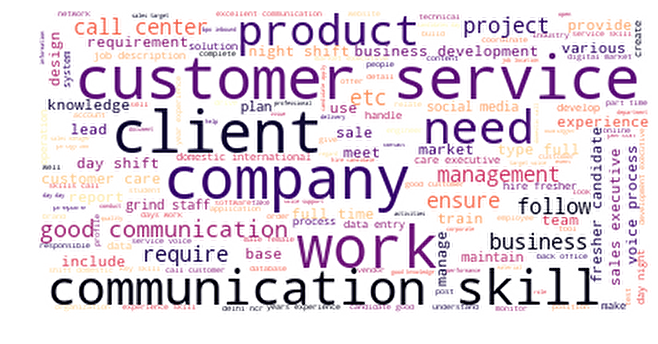

In [0]:
plt.figure(figsize=[11,11])
plt.imshow(wordcloud, interpolation="sinc")
plt.axis("off")
plt.show()

In [0]:
!wget https://microventures.com/wp-content/uploads/team-1697987_640.png >img1

--2019-07-16 08:46:30--  https://microventures.com/wp-content/uploads/team-1697987_640.png
Resolving microventures.com (microventures.com)... 146.148.53.236
Connecting to microventures.com (microventures.com)|146.148.53.236|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31568 (31K) [image/png]
Saving to: ‘team-1697987_640.png’

team-1697987_640.pn 100%[===================>]  30.83K  --.-KB/s    in 0.04s   

2019-07-16 08:46:30 (806 KB/s) - ‘team-1697987_640.png’ saved [31568/31568]



In [0]:
!mv team-1697987_640.png wf.png

In [0]:
img = Image.open("wf.png").convert('RGBA')
x = np.array(img)
r, g, b, a = np.rollaxis(x, axis = -1)
r[a == 0] = 255
g[a == 0] = 255
b[a == 0] = 255
x = np.dstack([r, g, b, a])
img = Image.fromarray(x, 'RGBA')


In [0]:
thresh = 200
fn = lambda x : 255 if x <= thresh else 0
wf_mask = img.convert('L').point(fn, mode='1')
wf_mask = np.array(wf_mask)


In [0]:
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val

In [0]:
transformed_wf_mask = np.ndarray((wf_mask.shape[0],wf_mask.shape[1]), np.int32)

for i in range(len(wf_mask)):
    transformed_wf_mask[i] = list(map(transform_format, wf_mask[i]))

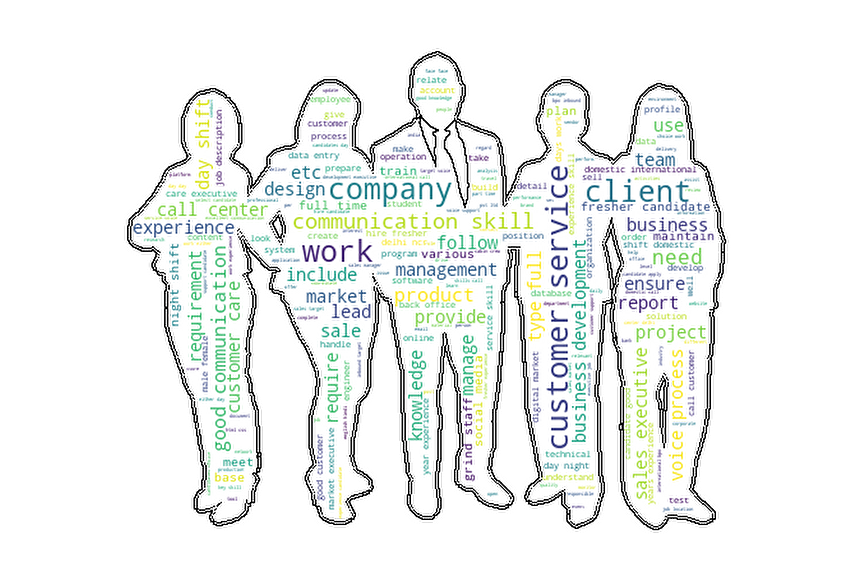

In [0]:
wc = WordCloud(background_color="white", mask=transformed_wf_mask,
               stopwords=stopwords, contour_width=.1, contour_color='black')

# Generate a wordcloud
wc.generate(bunch_text)

# show
plt.figure(figsize=[20,10])
plt.imshow(wc, interpolation="sinc")
plt.axis("off")
plt.show()

##Thats all Folks!!!

---

